In [1]:
import pkg_resources

_qiskit_ = False
for package in ['qiskit']:
    try:
        dist = pkg_resources.get_distribution(package)
        print('{} ({}) is installed.'.format(dist.key, dist.version))
        _qiskit_ = True
    except pkg_resources.DistributionNotFound:
        print('{} is NOT installed, ensure data files are present in the same working directory.'.format(package))

qiskit (0.30.1) is installed.


In [2]:
%matplotlib inline

if _qiskit_ == True:
    # Importing standard Qiskit libraries
    from qiskit import *
    from qiskit import QuantumCircuit, execute, Aer, IBMQ
    from qiskit.compiler import transpile, assemble
    from qiskit.tools.jupyter import *
    from qiskit.visualization import *
    from qiskit.providers.aer import AerSimulator
    # Import the RB Functions
    import qiskit.ignis.verification.randomized_benchmarking as rb
    from qiskit.test.mock import FakeParis
    from qiskit.test.mock import FakeCambridgeAlternativeBasis
    from qiskit import transpile, schedule
    from qiskit.circuit import QuantumRegister, QuantumCircuit, Gate
    from qiskit.pulse import Schedule, Play, ControlChannel
    from qiskit.pulse.library import GaussianSquare
    from qiskit.ignis.verification.tomography import process_tomography_circuits
    from qiskit.test.mock import FakeAlmaden, FakeValencia, FakeCambridge, FakeManhattan, FakeSydney, FakeMumbai, FakeRochester, FakeMontreal, FakeToronto, FakeTokyo
    from qiskit.visualization.pulse_v2 import draw, IQXSimple, IQXDebugging
    from qiskit.tools.monitor import job_monitor
    # Loading your IBM Q account(s)
    provider = IBMQ.load_account()

# Qiskit independent libraries
import math
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re as regex
import sys
import pickle
import networkx as nx
import time
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn import svm

#plt.style.use(['dark_background'])
plt.rcParams['figure.figsize'] = [10, 6]
# Set general font size
plt.rcParams['font.size'] = '16'
plt.rcParams['savefig.dpi'] = 100

In [4]:
class config():
    scaling_factor = 10**(-7) # arbitrary scaling factor for IQ values
    backend = None
    nq = 5 # number of qubits
    num_shots = 8192
    csv_filename = 'readout_data'
    baseline_classifier = []
    test_string = '10101'
    kernel = 'linear'
    num_test_exps = 10

cfg = config()

if _qiskit_ == True:
    backend = provider.get_backend('ibmq_bogota') # get a handle of the quantum computer
    
    ####################################
    # IBM Bogota (5 qubits)
    # q0 ---- q1 ---- q2 ---- q3 ---- q4
    # 5 frequency multiplexed qubits:
    #     All 5 qubits share a common
    #     feedline.
    ####################################
    cfg.backend = provider.get_backend('ibmq_bogota')
    cfg.nq = backend.configuration().num_qubits
    
    def generate_binary_strings(bit_count):
        binary_strings = []
        def genbin(n, bs=''):
            if len(bs) == n:
                binary_strings.append(bs)
            else:
                genbin(n, bs + '0')
                genbin(n, bs + '1')

        genbin(bit_count)
        return binary_strings
    
    def get_ckt():
        return QuantumCircuit(cfg.nq, cfg.nq)
    
    def circuit_synth(): # synthesize a list of circuits to characterize readout
        # return list of tuples (circuit, expected outcome)
        # warning: Can't run more than 100 circuits at a time
        ckt_list = []
        # passive circuits
        ckt = get_ckt()
        # all 0
        for i in range(cfg.nq):
            ckt.measure(i, i)
            ckt_list.append(tuple((ckt, '0', i)))
            ckt = get_ckt()
        # all 1
        ckt = get_ckt()
        for i in range(cfg.nq):
            ckt.x(i)
            ckt.measure(i, i)
            ckt_list.append(tuple((ckt, '1', i)))
            ckt = get_ckt()
        # Crosstalk characterization circuits ### can be different based on methodology
        ckt = get_ckt()
        bitstrings = generate_binary_strings(cfg.nq)
        for bs in bitstrings:
            for i, bit in enumerate(bs):
                if bit == '1':
                    ckt.x(i)
            for i in range(cfg.nq):
                ckt.measure(i, i)
            ckt_list.append(tuple((ckt, bs, 'all')))
            ckt = get_ckt()
        return ckt_list
    
    def extract_ckts(ckt_list):
        return [x[0] for x in ckt_list]
    
    def run_job(ckt_list, shots=1024):
        # return job handle for the entire run
        ckts = extract_ckts(ckt_list)
        job = execute(ckts, backend=cfg.backend, meas_level=1, meas_return='single', shots=shots)
        return job
    
    def extract_results(job, num_exps):
        results = []
        for i in range(num_exps):
            results.append(job.result().get_memory(i))
        return results
    
    def format_results(results, ckt_list):
        # splits and appends the master result data structure to get a list of tuples (measurement, outcome) for every qubit
        ord_results = [[] for q in range(cfg.nq)]
        for i, result in enumerate(results):
            #bitstring = (ckt_list[i])[1]
            qubit = (ckt_list[i])[2]
            if qubit == 'all':
                # all qubits being measured
                qubit = [i for i in range(cfg.nq)]
            else:
                qubit = list([qubit])
            for qb in qubit:
                if type(ord_results[qb]) != list:
                    ord_results[qb] = []
                shots = []
                for shot in result:
                    shots.append(shot[qb])
                ord_results[qb].append(shots)#(tuple((shot[qb], outcome)))
        return ord_results
    
    def get_expected_results(ckt_list):
        # get the expected binary classification for all qubits for every experiment
        y = [[] for q in range(cfg.nq)]
        for ckt in ckt_list:
            bitstring = ckt[1]
            qubit = ckt[2]
            if qubit == 'all':
                # all qubits being measured
                qubit = [i for i in range(cfg.nq)]
            else:
                qubit = list([qubit])
            for qb in qubit:
                if len(bitstring) > 1:
                    if bitstring[qb] == '1':
                        y[qb].append(bitstring[qb])
                    elif bitstring[qb] == '0':
                        y[qb].append('-1')
                else:
                    if bitstring[0] == '1':
                        y[qb].append(bitstring[0])
                    elif bitstring[0] == '0':
                        y[qb].append('-1')
        return y
    
    def dump_data(data, labels, num_shots):
        # Create a separate file for all qubits
        # Each file will have dimensions (num_ckts * num_shots)
        for qb in range(len(data)):
            d = np.array(data[qb])
            y = np.array(labels[qb])
            d_flat = d.flatten()
            y_flat = []
            dr, dc = d.shape
            y_ind = 0
            for i, _ in enumerate(d_flat):
                y_flat.append(y[y_ind])
                y_ind = math.floor(i / dc)
            y_flat = np.array(y_flat)
            y_flat = y_flat.flatten()
            d_flat_real = np.real(d_flat) * cfg.scaling_factor
            d_flat_imag = np.imag(d_flat) * cfg.scaling_factor
            filename = cfg.csv_filename + '_q' + str(qb) + '_' + str(num_shots) + '.csv'
            df = pd.DataFrame({"DataR":d_flat_real, "DataI":d_flat_imag, "y":y_flat})
            df.to_csv(filename, index=False)
        return

In [6]:
# # Generate data dump files
if _qiskit_ == True:
    test_shots = [256, 512, 1024, 2048, 4096]
    for shot in test_shots:
        cfg.num_shots = shot
        cfg.csv_filename = 'readout_data'
        ckt_list = circuit_synth()
        print('Number of circuits: ', len(ckt_list), "; Number of shots used for training: ", shot)
        job = run_job(ckt_list, shots=cfg.num_shots)
        job_monitor(job) # wait for job to complete
        results = extract_results(job, len(ckt_list))
        data = format_results(results, ckt_list)
        y = get_expected_results(ckt_list)
        dump_data(data, y, num_shots=cfg.num_shots)

Number of circuits:  42
Job Status: job has successfully run
Number of circuits:  42
Job Status: job has successfully run
Number of circuits:  42
Job Status: job has successfully run
Number of circuits:  42
Job Status: job has successfully run
Number of circuits:  42
Job Status: job has successfully run


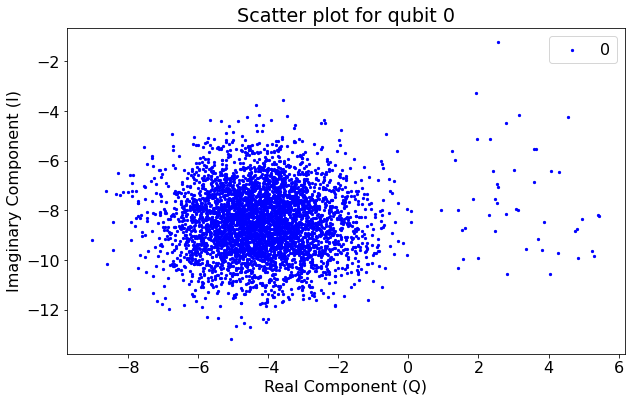

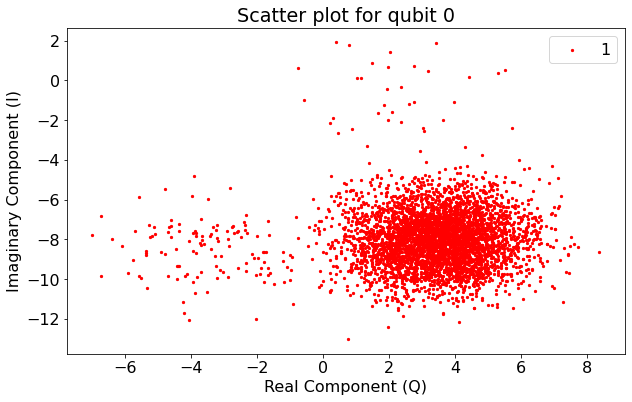

In [5]:
# Looking at data for qubit 0
file = pd.read_csv('readout_data_q0_256.csv')
d0_r = np.array(file['DataR'])
d0_i = np.array(file['DataI'])
plt.scatter(file[file["y"] == -1]["DataR"],file[file["y"] == -1]["DataI"], label="0", color='blue',s=5)
plt.xlabel('Real Component (Q)')
plt.ylabel('Imaginary Component (I)')
plt.title('Scatter plot for qubit 0')
plt.legend()
plt.show()
plt.scatter(file[file["y"] == 1]["DataR"],file[file["y"] == 1]["DataI"], label="1",color='red', s=5)
plt.xlabel('Real Component (Q)')
plt.ylabel('Imaginary Component (I)')
plt.title('Scatter plot for qubit 0')
plt.legend()
plt.show()

## Optimization

In [10]:
classifier_dict = {}
cfg.kernel = 'linear'
test_shots = [256, 512, 1024, 2048, 4096]

In [11]:
def init_classifiers():
    classifier_dict = {}

def create_classifiers(shots):
    clf_list = []
    for qubit in range(0, cfg.nq):
        filename = cfg.csv_filename + '_q' + str(qubit) + '_' + str(shots) + '.csv'
        file = pd.read_csv(filename)
        dataR = file['DataR']
        dataI = file['DataI']
        y = file['y']
        clf = svm.SVC(kernel=cfg.kernel)
        clf.fit(np.array([dataR, dataI]).T, y)
        clf_list.append(clf)
    return clf_list

training_time = []

def training(shots):
    training_time = []
    for shot in shots:
        print('Training for {} shots'.format(shot))
        stime = time.time()
        clf_list = create_classifiers(shot)
        etime = time.time()
        print('Training time: {} sec'.format(etime - stime))
        training_time.append(etime - stime)
        classifier_dict[shot] = clf_list
    return

In [13]:
init_classifiers()
cfg.kernel = 'linear'
training(test_shots) 

Training for 256 shots
Training time: 4.813083648681641 sec
Training for 512 shots
Training time: 16.257659673690796 sec
Training for 1024 shots
Training time: 135.41712284088135 sec
Training for 2048 shots
Training time: 314.5294954776764 sec
Training for 4096 shots
Training time: 1498.316174507141 sec


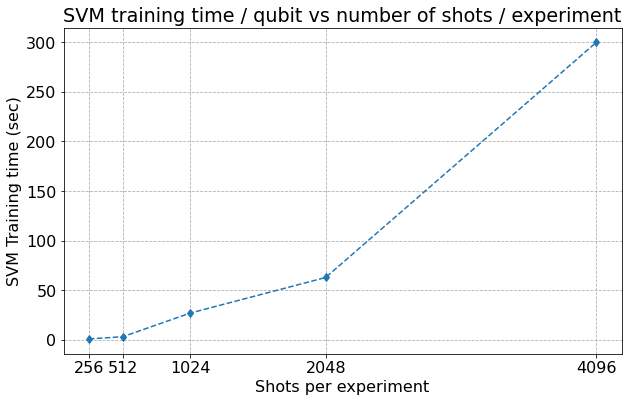

In [31]:
plt.plot(test_shots, np.array(training_time) / cfg.nq, 'd--')
#plt.yscale('log')
plt.grid(linestyle='--')
plt.xlabel('Shots per experiment')
plt.ylabel('SVM Training time (sec)')
plt.title('SVM training time / qubit vs number of shots / experiment')
plt.xticks(test_shots)
plt.show()

In [41]:
print(classifier_dict)

{256: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 512: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 1024: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 2048: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 4096: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')]}


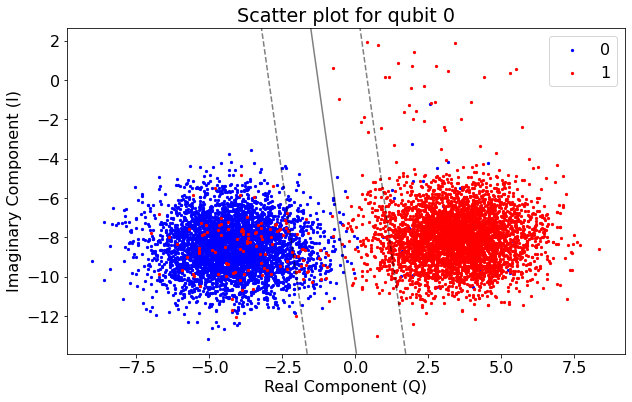

In [21]:
file = pd.read_csv('readout_data_q0_256.csv')
d0_r = np.array(file['DataR'])
d0_i = np.array(file['DataI'])
plt.scatter(file[file["y"] == -1]["DataR"],file[file["y"] == -1]["DataI"], label="0", color='blue',s=5)
plt.scatter(file[file["y"] == 1]["DataR"],file[file["y"] == 1]["DataI"], label="1",color='red', s=5)
plt.xlabel('Real Component (Q)')
plt.ylabel('Imaginary Component (I)')
plt.title('Scatter plot for qubit 0')
plt.legend()
clfs = classifier_dict[256]
clf = clfs[0]
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.show()

## Evaluations

##### Evaluation functions

In [ ]:
def eval_ckts():
    # GHZ state - 100 copies
    ckt = QuantumCircuit(cfg.nq, cfg.nq)
    for i in range(cfg.nq):
        if i == 0:
            ckt.h(i)
        else:
            ckt.cx(i - 1, i)
    for i in range(cfg.nq):
        ckt.measure(i, i)
    ckts = [ckt for i in range(cfg.num_test_exps)]
    return ckts

def get_results(result, exps):
    if type(exps) != list:
        exps = list([exps])
    num_exps = len(exps)
    results = [[] for i in range(0, cfg.nq)]
    for r in result:
        shot = np.array(r)
        for i in range(cfg.nq):
            results[i].extend(shot[:, i])
    return results

def run_wrapper(backend, exps, shots):
    job = execute(exps, backend=backend, meas_level=1, meas_return='single', shots=shots)
    #job_monitor(job)
    return job

def get_counts(result, exps, clf_shots):
    classifiers = classifier_dict[clf_shots]
    results = get_results(result, exps)
    # get predictions
    predictions = [np.array([]) for i in range(cfg.nq)]
    for i in range(cfg.nq):
        data = results[i]
        clf = classifiers[i]
        pred = clf.predict(np.array([np.real(data) * cfg.scaling_factor, np.imag(data) * cfg.scaling_factor]).T)
        pred = [0 if x == -1 else 1 for x in pred]
        predictions[i] = np.array(pred)
    predictions = np.array([predictions[i] for i in range(cfg.nq)])
    print(predictions.shape)
    counts = {}
    for i in range(0, len(predictions[0])):
        bitstring = ''
        bitstring = bitstring.join([str(i) for i in predictions[:, i]])
        if bitstring not in counts.keys():
            counts[bitstring] = 1
        else:
            counts[bitstring] += 1
    return counts

def infer_opt(data,w, gamma):
    temp = [w[i] * data[i] for i in range(0, len(data))]
#     val = temp[0] + gamma
    val = sum(temp) + gamma
    return int(val > 0)

def infer(data, qubit):
    print(qubit)
    c = cfg.baseline_classifier
    c = c[qubit]
    dist0 = np.sqrt((data[0] - (c[0])[0])**2 + (data[1] - (c[0])[1])**2)
    dist1 = np.sqrt((data[0] - (c[1])[0])**2 + (data[1] - (c[1])[1])**2)
    return int(dist0 > dist1)

def get_counts_means(result, exps):
    results = get_results(result, exps)
    predictions = [np.array([]) for i in range(cfg.nq)]
    for i in range(0, cfg.nq):
        data = results[i]
        pred = []
        for i, d in enumerate(data):
            print(d)
            pred.append(infer([np.real(d) * cfg.scaling_factor, np.imag(d) * cfg.scaling_factor], i))
        predictions[i] = np.array(pred)
    predictions = np.array([predictions[i] for i in range(cfg.nq)])
    counts = {}
    for i in range(0, len(predictions[0])):
        bitstring = ''
        bitstring = bitstring.join([str(i) for i in predictions[:, i]])
        if bitstring not in counts.keys():
            counts[bitstring] = 1
        else:
            counts[bitstring] += 1
    return counts

def classify_opt(dataR, dataI, qubit,w,gamma):
    counts = {'0':0, '1':0}
    pred = []
    for i, data in enumerate(dataR):
        temp = [dataR[i], dataI[i]]
        inference = infer_opt(temp,w,gamma)
        counts[str(inference)] += 1
        pred.append(inference)
    return counts, pred

def classify(dataR, dataI, qubit):
    counts = {'0':0, '1':0}
    pred = []
    for i, data in enumerate(dataR):
        temp = [dataR[i], dataI[i]]
        inference = infer(temp, qubit)
        counts[str(inference)] += 1
        pred.append(inference)
    return counts,pred

def baseline_classifier(shots):
    c = []
    for q in range(0, cfg.nq):
        fn = 'readout_data_q' + str(q) + '_' + str(shots) + '.csv'
        file = pd.read_csv(fn)
        dr = file['DataR']
        di = file['DataI']
        y = file['y']
        mean_0 = [0, 0]
        mean_1 = [0, 0]
        for i, label in enumerate(y):
            if label == -1:
                mean_0[0] += dr[i] / len(y)
                mean_0[1] += di[i] / len(y)
            else:
                mean_1[0] += dr[i] / len(y)
                mean_1[1] += di[i] / len(y)
        c.append([mean_0, mean_1])
    cfg.baseline_classifier = c
    return 

if _qiskit_ == True:
    def generate_test_data():
        ckt = QuantumCircuit(cfg.nq, cfg.nq)
        state = cfg.test_string
        for i, bit in enumerate(state):
            if bit == '1':
                ckt.x(i)
        for i in range(0, cfg.nq):
            ckt.measure(i, i)
        job = execute(ckt, backend=cfg.backend, shots=8192, meas_level=1, meas_return='single')
        job_monitor(job)
        cfg.csv_filename = 'test_data'
        ckt_list = [tuple((ckt, state, 'all'))]
        results = extract_results(job, len(ckt_list))
        data = format_results(results, ckt_list)
        y = get_expected_results(ckt_list)
        dump_data(data, y)
        return

In [82]:
exps = eval_ckts()
backend = cfg.backend
shots = 8192
job_opt = run_wrapper(backend=backend, shots=shots, exps=exps)
job = execute(exps, backend=backend, shots=shots)
job_monitor(job_opt)
job_monitor(job)
results_opt = extract_results(job_opt, cfg.num_test_exps)
results = job.result()

Job Status: job has successfully run
Job Status: job has successfully run


In [ ]:
results_opt = None
results = None
with open("result_opt.dmp", "wb") as loadFile:
    results_opt = pickle.load(loadFile)
with open("result.dmp", "wb") as loadFile:
    results = pickle.load(loadFile)

In [146]:
# save data
with open("result_opt.dmp", "wb") as saveFile:
    pickle.dump(results_opt, saveFile)
    
with open("result.dmp", "wb") as saveFile2:
    pickle.dump(results, saveFile2)

In [183]:
baseline_classifier(512)

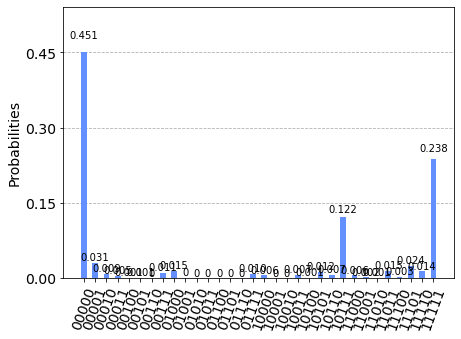

In [94]:
plot_histogram(results.get_counts())
cumulative_result = {}
for i, result in enumerate(results.get_counts()):
    if i == 0:
        cumulative_result = result
    else:
        for key in result.keys():
            if key not in cumulative_result.keys():
                cumulative_result[key] = result[key]
            else:
                cumulative_result[key] += result[key]

plot_histogram(cumulative_result)

In [ ]:
counts_mean = get_counts_means(results_opt, exps)

In [236]:
classifiers_linear = classifier_dict

In [280]:
print(classifier_dict)

{256: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 512: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 1024: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 2048: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')], 4096: [SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear'), SVC(kernel='linear')]}


In [279]:
counts = [{} for shot in test_shots]
for i, shot in enumerate(test_shots):
    counts[i] = get_counts(results_opt, exps, shot)

(5, 81920)
(5, 81920)
(5, 81920)
(5, 81920)
(5, 81920)


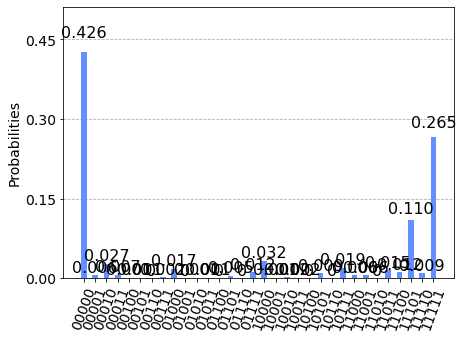

In [286]:
plot_histogram(counts[1])

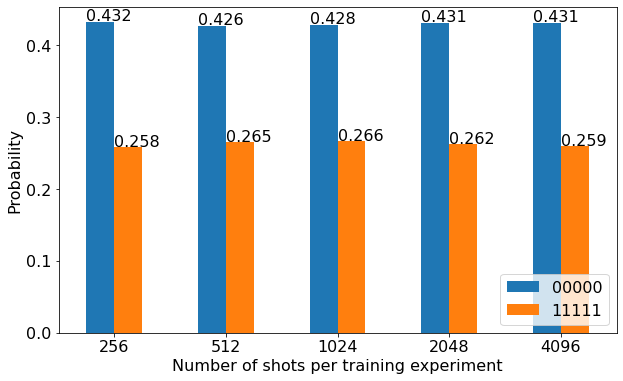

In [303]:
total_shots = 81920
zeros = np.array([(counts[i])['00000'] for i in range(0, len(counts))]) / total_shots
ones = np.array([(counts[i])['11111'] for i in range(0, len(counts))]) / total_shots
df = pd.DataFrame({'00000':zeros, '11111':ones}, test_shots)
ax = df.plot.bar(rot=0)
ax.legend(loc='lower right')
ax.set_xlabel('Number of shots per training experiment')
ax.set_ylabel('Probability')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)), (p.get_x() * 1, p.get_height() * 1.005))